<a href="https://colab.research.google.com/github/joaogabrielferr/Projeto-T.InteligenciaComputacional/blob/main/Projeto_de_T%C3%B3picos_em_Intelig%C3%AAncia_Computacional_ETAPA_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Projeto de Tópicos em Inteligência Computacional**

 O objetivo é utilizar a base de dados disponível em https://www.kaggle.com/fedesoriano/stroke-prediction-dataset para prever se uma pessoa terá um AVC, portanto será escolhida uma abordagem de classificação. 

In [1]:
import numpy as np
import pandas as pd
import sklearn
import seaborn as sea
import matplotlib.pyplot as plt
from google.colab import files
import io

uploaded = files.upload()

Saving healthcare-dataset-stroke-data.csv to healthcare-dataset-stroke-data.csv


In [2]:
dados = pd.read_csv(io.BytesIO(uploaded['healthcare-dataset-stroke-data.csv']))
dados.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


Existem 11 colunas com características. As colunas são: gênero, idade, hipertenção(sim ou não), doença cardiovascular(sim ou não), ja se casou, tipo de trabalho, tipo de redidencia, nível de glicose, índice de massa corporal, se a pessoa fuma ou ja fumou, e por fim uma coluna indicando se a pessoa ja teve uma AVC(sim ou não).
Existe uma coluna extra chamada id, como ela é desnecessária, ela será excluida dos dados.

In [3]:
dados = dados.drop("id",axis = 1)
dados.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


# **Resolvendo valores nulos**

In [4]:
dados.isnull().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

A coluna com informações sobre o índice de massa corporal apresenta vários valores nulos. As  linhas com os valores nulos serão apagadas.

In [5]:
dados = dados.dropna()
dados.isnull().sum()

gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

# **Correlação entre as características**

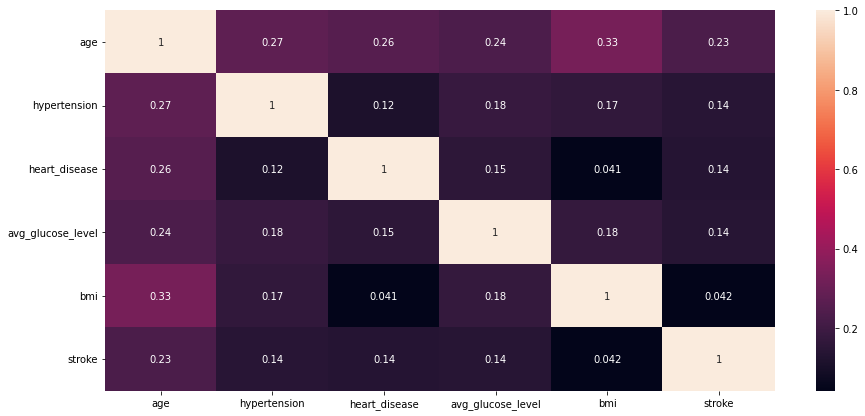

In [6]:
#Correlação entre AVC com as outras características numéricas
plt.figure(figsize=(15,7))
sea.heatmap(dados.corr(),annot=True);

Existe uma correlação entre AVC e idade.

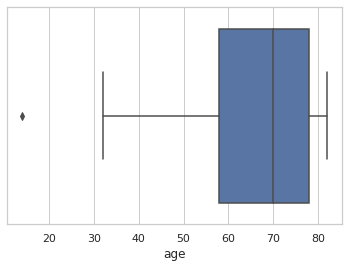

In [7]:
sea.set_theme(style="whitegrid")
dados2 = pd.DataFrame(dados, columns=['age', 'stroke'])
dados2 = dados.loc[dados['stroke'] > 0]
idade = sea.boxplot(x=dados2["age"])

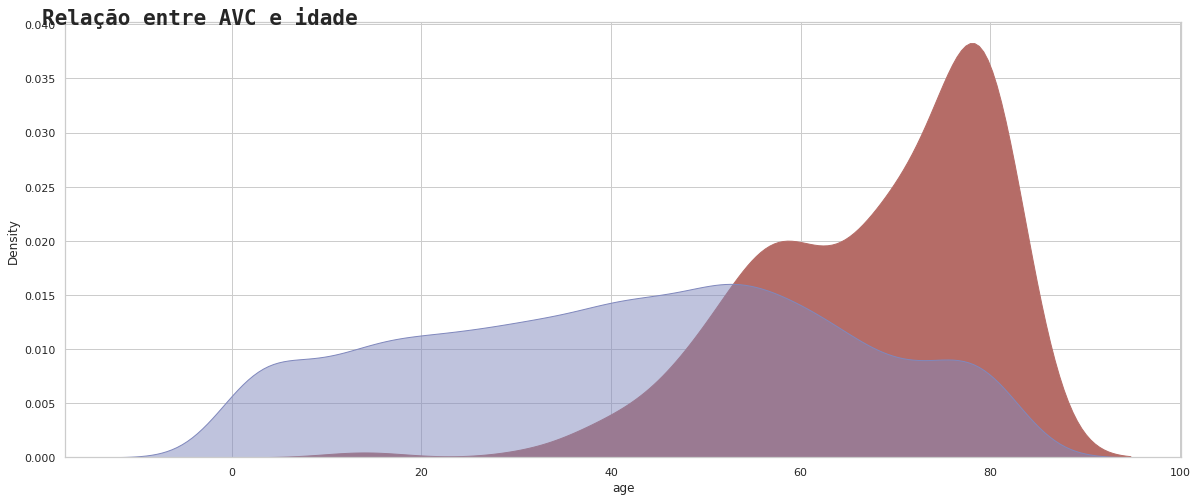

In [8]:
fig=plt.figure(figsize=(20,8),facecolor='white')

ax=[None for i in range(1)]
gs=fig.add_gridspec(1,1)
gs.update(wspace=0, hspace=0.8)

ax[0]=fig.add_subplot(gs[0,0])

ax[0].text(-20,0.04,'Relação entre AVC e idade',fontsize=21,fontweight='bold', fontfamily='monospace')

sea.kdeplot(data=dados[dados.stroke==1],x='age',ax=ax[0],shade=True,color='#b56c67',alpha=1)
sea.kdeplot(data=dados[dados.stroke==0],x='age',ax=ax[0],shade=True,color='#8088bd',alpha=0.5)



Analisando os gráficos podemos perceber que quanto mais velha a pessoa, maiores as chances de ela ter um AVC.


In [9]:
import plotly.express as ex
torta = ex.pie(dados, names = "stroke")
torta.update_layout(title='<b>Proporção de amostras com AVC e sem AVC<b>')
torta.show()

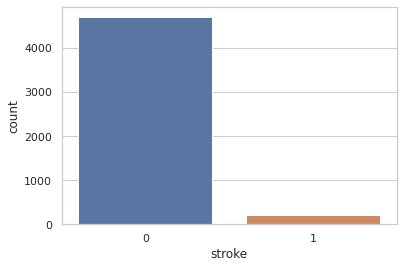

In [10]:
ax = sea.countplot(x=dados.stroke)

O dataset esta muito desbalanceado. O número de pessoas que ja não tiveram um AVC é muito maior que o número de pessas que já tiveram.

# **Preparação para criar os modelos de classificação**

Primeiro, as variáveis categoricas vão ser convertidas para variáveis numéricas

In [11]:
#Convertendo variáveis categoricas em numéricas


dados.ever_married = dados.ever_married.map({"Yes":1,"No":0})
dados.work_type = dados.work_type.map({"Private":0,"Self-employed" :1, "Govt_job": 2,"children": 3,"Never_worked":4})
dados.Residence_type = dados.Residence_type.map({"Urban":0,"Rural":1})
dados.smoking_status = dados.smoking_status.map({"formerly smoked":0,"never smoked":1,"smokes":2,"Unknown":3})
dados.gender = dados.gender.map({"Female":0,"Male":1,"Other":2})

dados.head(10)



,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,1,67.0,0,1,1,0,0,228.69,36.6,0,1
2,1,80.0,0,1,1,0,1,105.92,32.5,1,1
3,0,49.0,0,0,1,0,0,171.23,34.4,2,1
4,0,79.0,1,0,1,1,1,174.12,24.0,1,1
5,1,81.0,0,0,1,0,0,186.21,29.0,0,1
6,1,74.0,1,1,1,0,1,70.09,27.4,1,1
7,0,69.0,0,0,0,0,0,94.39,22.8,1,1
9,0,78.0,0,0,1,0,0,58.57,24.2,3,1
10,0,81.0,1,0,1,0,1,80.43,29.7,1,1
11,0,61.0,0,1,1,2,1,120.46,36.8,2,1


Os dados precisam ser balanceados. O método SMOTE vai ser usado

In [12]:
#Utilizando o metodo SMOTE para balancear os valores da coluna target(stroke)

from imblearn.over_sampling import SMOTE

Xdesbalanceado = dados.loc[:, dados.columns != "stroke"]
ydesbalanceado = dados.stroke

smote = SMOTE(random_state=2)

X, y = smote.fit_resample(Xdesbalanceado, ydesbalanceado.ravel())

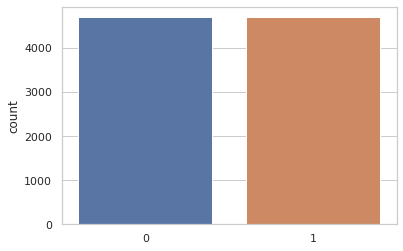

In [13]:
ax = sea.countplot(x=y)

In [14]:
print("Antes do OverSampling, qtd de amostras com valor '1': {}".format(sum(ydesbalanceado==1)))
print("Antes do OverSampling, qtd de amostras com valor '0': {} \n".format(sum(ydesbalanceado==0)))
print("Depois OverSampling, qtd de amostras com valor '1': {}".format(sum(y==1)))
print("Depois OverSampling, qtd de amostras com valor '0': {}".format(sum(y==0)))

Antes do OverSampling, qtd de amostras com valor '1': 209
Antes do OverSampling, qtd de amostras com valor '0': 4700 

Depois OverSampling, qtd de amostras com valor '1': 4700
Depois OverSampling, qtd de amostras com valor '0': 4700


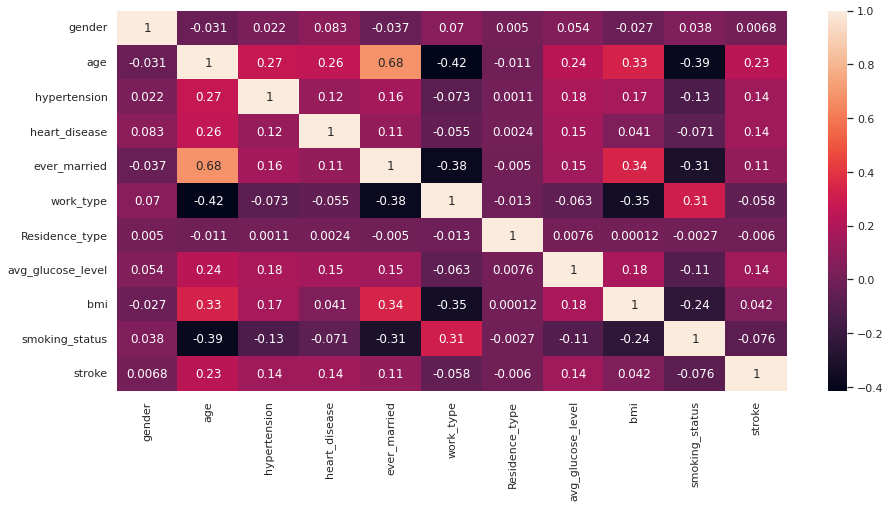

In [15]:
plt.figure(figsize=(15,7))
sea.heatmap(dados.corr(),annot=True);

Os modelos serão ajustados de duas formas, primeiro utilizando características selecionadas por um modelo de seleção de características.
O modelo que vai ser utilizado é o SelectKBest. Nesse modelo, são selecionadas as k melhores características com base em algum teste estatístico. Nesse caso, o teste utilizado vai ser o Chi2, que mede a dependência entre variáveis estocásticas, o uso dessa função “elimina” os recursos com maior probabilidade de serem independentes da classe e, portanto, irrelevantes para a classificação.



In [16]:

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2


test = SelectKBest(chi2, k=4)
fit = test.fit(X, y)
features = fit.transform(X)


cols = fit.get_support(indices=True)

print("usando kbest com chi2:")
print(dados.iloc[:,cols])




usando kbest com chi2:
       age  work_type  avg_glucose_level  smoking_status
0     67.0          0             228.69               0
2     80.0          0             105.92               1
3     49.0          0             171.23               2
4     79.0          1             174.12               1
5     81.0          0             186.21               0
...    ...        ...                ...             ...
5104  13.0          3             103.08               3
5106  81.0          1             125.20               1
5107  35.0          1              82.99               1
5108  51.0          0             166.29               0
5109  44.0          2              85.28               3

[4909 rows x 4 columns]


Com k = 4, as melhores colunas selecionadas foram idade, tipo de trabalho, nível médio de glicose e a coluna que indica se é, ja foi ou nunca foi fumante.

In [17]:


#Xn = X.drop(['ever_married', 'gender', 'Residence_type', 'hypertension','heart_disease','bmi'], axis = 1)

Xnn = X[['age','work_type','avg_glucose_level','smoking_status']]


Os modelos de classficação que serão utilizados são: Regressão Logística, Árvore de Decisão, Naive Bayes e Kneighbors

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report

print(Xnn)
X_train, X_test, y_train, y_test = train_test_split(Xnn, y, test_size= 0.2,random_state = 1)

modelos = []

modelos.append([LogisticRegression(random_state=0,max_iter = 5000), 'Regressão Logistica'])
modelos.append([DecisionTreeClassifier(random_state=0) ,' Arvore de Decisão'])
modelos.append([GaussianNB(),'Naive Bayes'])
modelos.append([KNeighborsClassifier(), 'Kneighbors'])


for i in range(len(modelos)):
   print(modelos[i][1],":")
   modelo = modelos[i][0]
   modelo.fit(X_train,y_train)
   y_pred = modelo.predict(X_test)
   precisao = precision_score(y_test,y_pred)
   print("precisao:\n",precisao)
   crosstab = pd.crosstab(y_test, y_pred, rownames=['Real'], colnames=['Predito'], margins=True)
   print("crosstab:\n",crosstab)
   class_report = classification_report(y_test, y_pred)
   print("Classification report:\n",class_report)




            age  work_type  avg_glucose_level  smoking_status
0     67.000000          0         228.690000               0
1     80.000000          0         105.920000               1
2     49.000000          0         171.230000               2
3     79.000000          1         174.120000               1
4     81.000000          0         186.210000               0
...         ...        ...                ...             ...
9395  74.000000          0          70.509643               1
9396  67.775322          0         226.852487               0
9397  78.904435          1         198.727810               0
9398  81.386751          0          87.167324               0
9399  60.923763          0         198.739521               0

[9400 rows x 4 columns]
Regressão Logistica :
precisao:
 0.7542799597180262
crosstab:
 Predito    0    1   All
Real                   
0        690  244   934
1        197  749   946
All      887  993  1880
Classification report:
               precision 

Agora usando todas as características para ajustar o modelo, vamos ver se existe alguma melhora.

In [22]:
print(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2,random_state = 1)

modelos = []

modelos.append([LogisticRegression(random_state=0,max_iter = 5000), 'Regressão Logistica'])
modelos.append([DecisionTreeClassifier(random_state=0) ,' Arvore de Decisão'])
modelos.append([GaussianNB(),'Naive Bayes'])
modelos.append([KNeighborsClassifier(), 'Kneighbors'])


for i in range(len(modelos)):
   print(modelos[i][1],":")
   modelo = modelos[i][0]
   modelo.fit(X_train,y_train)
   y_pred = modelo.predict(X_test)
   precisao = precision_score(y_test,y_pred)
   print("precisao:\n",precisao)
   crosstab = pd.crosstab(y_test, y_pred, rownames=['Real'], colnames=['Predito'], margins=True)
   print("crosstab:\n",crosstab)
   class_report = classification_report(y_test, y_pred)
   print("Classification report:\n",class_report)




      gender        age  ...        bmi  smoking_status
0          1  67.000000  ...  36.600000               0
1          1  80.000000  ...  32.500000               1
2          0  49.000000  ...  34.400000               2
3          0  79.000000  ...  24.000000               1
4          1  81.000000  ...  29.000000               0
...      ...        ...  ...        ...             ...
9395       0  74.000000  ...  22.035532               1
9396       0  67.775322  ...  39.417003               0
9397       0  78.904435  ...  25.790856               0
9398       1  81.386751  ...  29.101388               0
9399       1  60.923763  ...  36.136659               0

[9400 rows x 10 columns]
Regressão Logistica :
precisao:
 0.7983789260385005
crosstab:
 Predito    0    1   All
Real                   
0        735  199   934
1        158  788   946
All      893  987  1880
Classification report:
               precision    recall  f1-score   support

           0       0.82      0.79      0

Portanto, podemos prever com 90% de precisão se uma pessoa terá um AVC dadas as características presentes no dataset.